# Cistopic analysis

In [1]:
import os
import pycisTopic
from pycisTopic.cistopic_class import create_cistopic_object
pycisTopic.__version__

'2.0a0'

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "PVALB")

In [4]:
!mkdir -p pycistopic_outputs

In [5]:
## Some meta information
path_to_blacklist = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/hg38_blacklist.v2.bed.gz"

In [6]:
## Prepare the sample_id pd.Dataframe, not sure if this is necessary
meta_df = pd.read_csv("PVALB_meta_data.tsv", header=0, sep="\t")
meta_df["sample_id"] = "PVALB"

In [7]:
from scipy import io
count_matrix = io.mmread("PVALB_atac_matrix.mtx")

In [8]:
cell_names_tb = pd.read_csv("PVALB_cell_barcodes.tsv", header=None, sep="\t")
cell_names = cell_names_tb[0].tolist()
region_names_tb = pd.read_csv("PVALB_atac_regions.tsv", header=None, sep="\t")
region_names = region_names_tb[0].tolist()
region_names = ["{}:{}-{}".format(*x.split("-")) for x in region_names]

In [9]:
cistopic_object = create_cistopic_object(
    fragment_matrix=count_matrix.tocsr(),
    cell_names=cell_names,
    region_names=region_names,
    path_to_blacklist=path_to_blacklist,
    project="PVALB",
    tag_cells=False
)

2024-05-27 13:31:44,348 cisTopic     INFO     Removing blacklisted regions
2024-05-27 13:31:45,624 cisTopic     INFO     Creating CistopicObject
2024-05-27 13:31:48,035 cisTopic     INFO     Done!


In [10]:
cistopic_object.add_cell_data(meta_df)

Columns ['sample_id'] will be overwritten


In [11]:
print(cistopic_object)

CistopicObject from project PVALB with n_cells × n_regions = 58062 × 549807


In [12]:
import pickle
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

In [13]:
# dispatch models to different clusters
!mkdir -p pycistopic_slurm/

In [14]:
slurm_script_template = (
    "#!/bin/bash\n"
    "#SBATCH -p condo\n"
    "#SBATCH -q condo\n"
    "#SBATCH -J {0}\n"
    "#SBATCH -N 3\n"
    "#SBATCH -c 8\n"
    "#SBATCH --mem 300G\n"
    "#SBATCH -t 8:00:00\n"
    "#SBATCH -o /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/PVALB/pycistopic_slurm/{0}.out\n"
    "#SBATCH -e /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/PVALB/pycistopic_slurm/{0}.err\n"
    "#SBATCH --mail-user biy022@health.ucsd.edu\n"
    "#SBATCH --mail-type FAIL\n"
    "#SBATCH -A csd772\n"
    "\n"
    "set -e\n"
    "source ~/.bashrc\n"
    "conda activate scenicplus\n"
    "\n"
    "cd /tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/PVALB/\n"
    "python3 02.1_mallet_script.py {0} "
    "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/PVALB/pycistopic_outputs/cistopic_object.pickle\n"
)

In [15]:
for n_topic in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    with open("pycistopic_slurm/model_{}_slurm.sh".format(n_topic), "w") as f:
        f.write(slurm_script_template.format(n_topic))

In [16]:
# Run models in cluster

In [17]:
models = []
for file in os.listdir("pycistopic_outputs"):
    if file.startswith("Topic") and file.endswith(".pkl"):
        model = pickle.load(open(os.path.join("pycistopic_outputs/", file), "rb"))
        models.append(model)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-27 14:52:56,160	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [18]:
pickle.dump(
    models,
    open("pycistopic_outputs/cistopic_models.pkl", "wb")
)

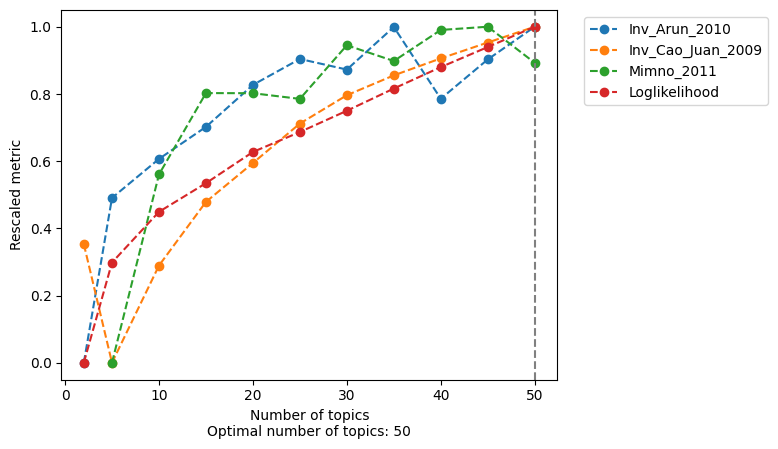

In [19]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(models, return_model = True)

In [20]:
cistopic_object.add_LDA_model(model)
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Clustering with cell to topics distributions

In [21]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap,
    harmony
)

In [22]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

In [23]:
find_clusters(
    cistopic_object,
    target="cell",
    k=20,
    res=[0.2, 0.4, 0.6, 0.8, 1.0],
    prefix="pycisTopic_",
    scale=True
)

2024-05-27 14:54:39,606 cisTopic     INFO     Finding neighbours


In [24]:
run_umap(cistopic_object, target="cell", scale=True)

2024-05-27 14:55:37,731 cisTopic     INFO     Running UMAP


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


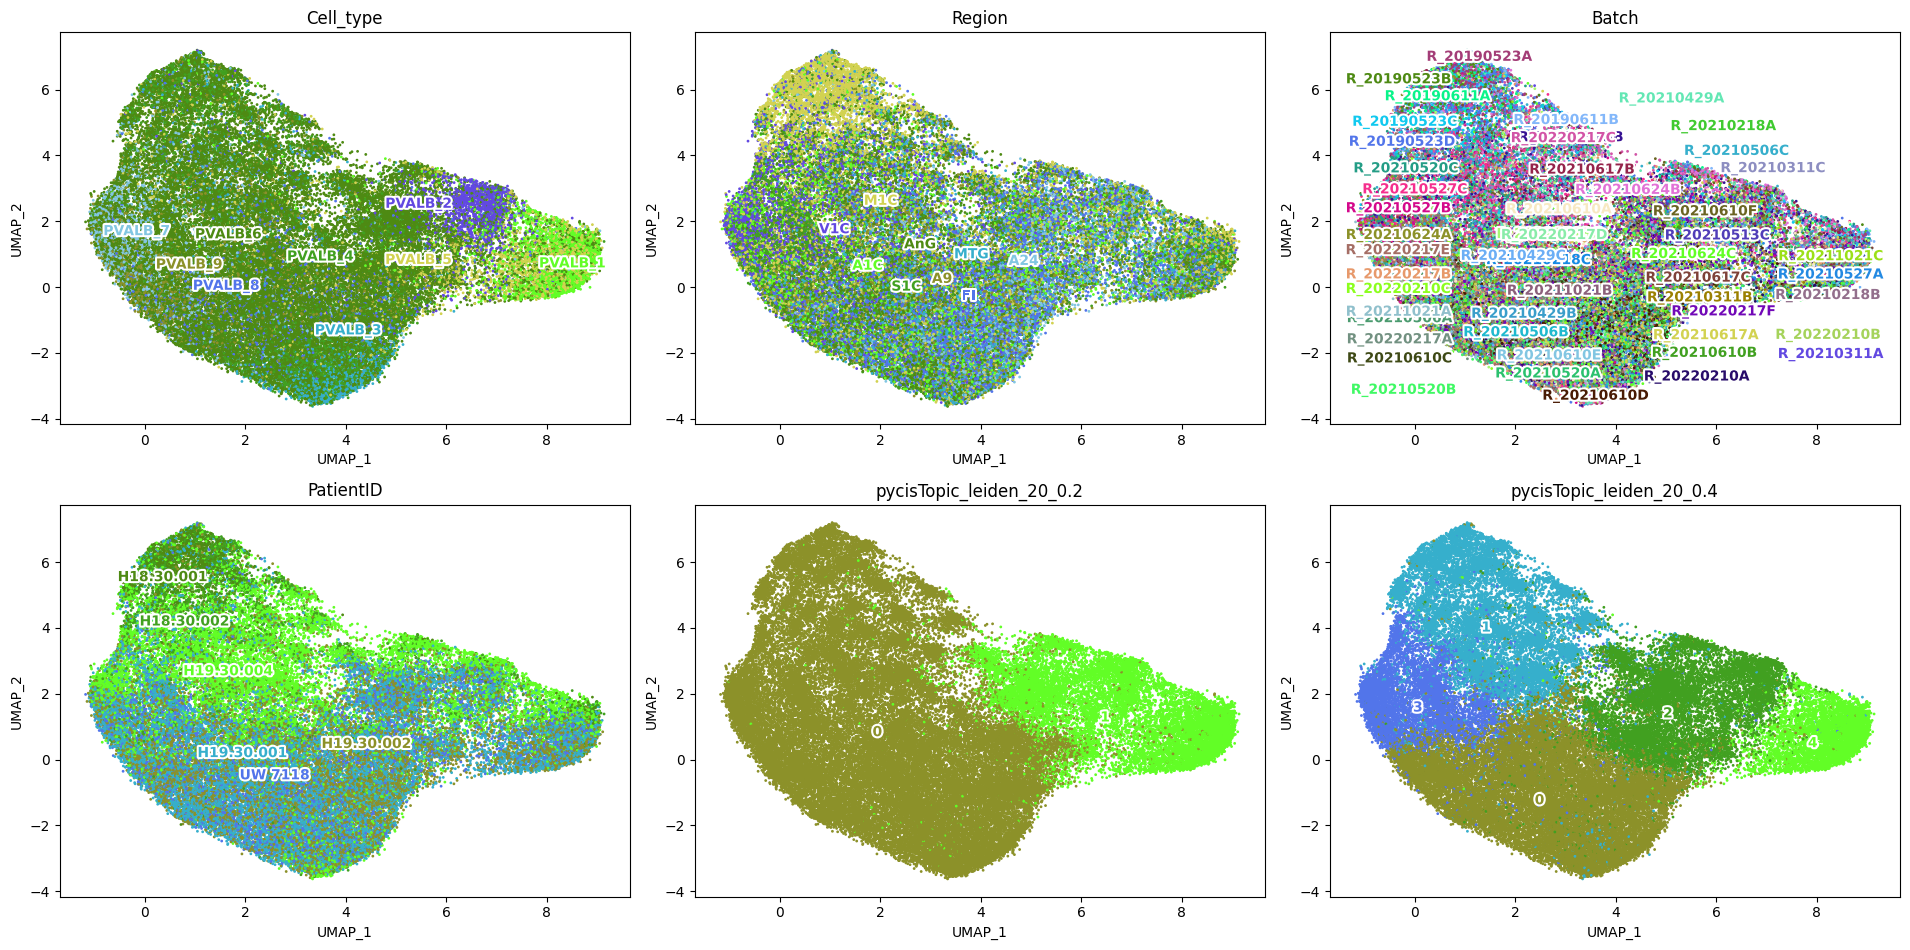

In [25]:
plot_metadata(
    cistopic_object,
    reduction_name="UMAP",
    variables=[
        "Cell_type", 
        "Region", 
        "Batch", 
        "PatientID",
        "pycisTopic_leiden_20_0.2",
        "pycisTopic_leiden_20_0.4"
    ],
    target="cell",
    num_columns=3,
    text_size=10,
    dot_size=1,
    show_legend=False
)

In [26]:
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Topic binarization

In [27]:
from pycisTopic.topic_binarization import binarize_topics

In [28]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

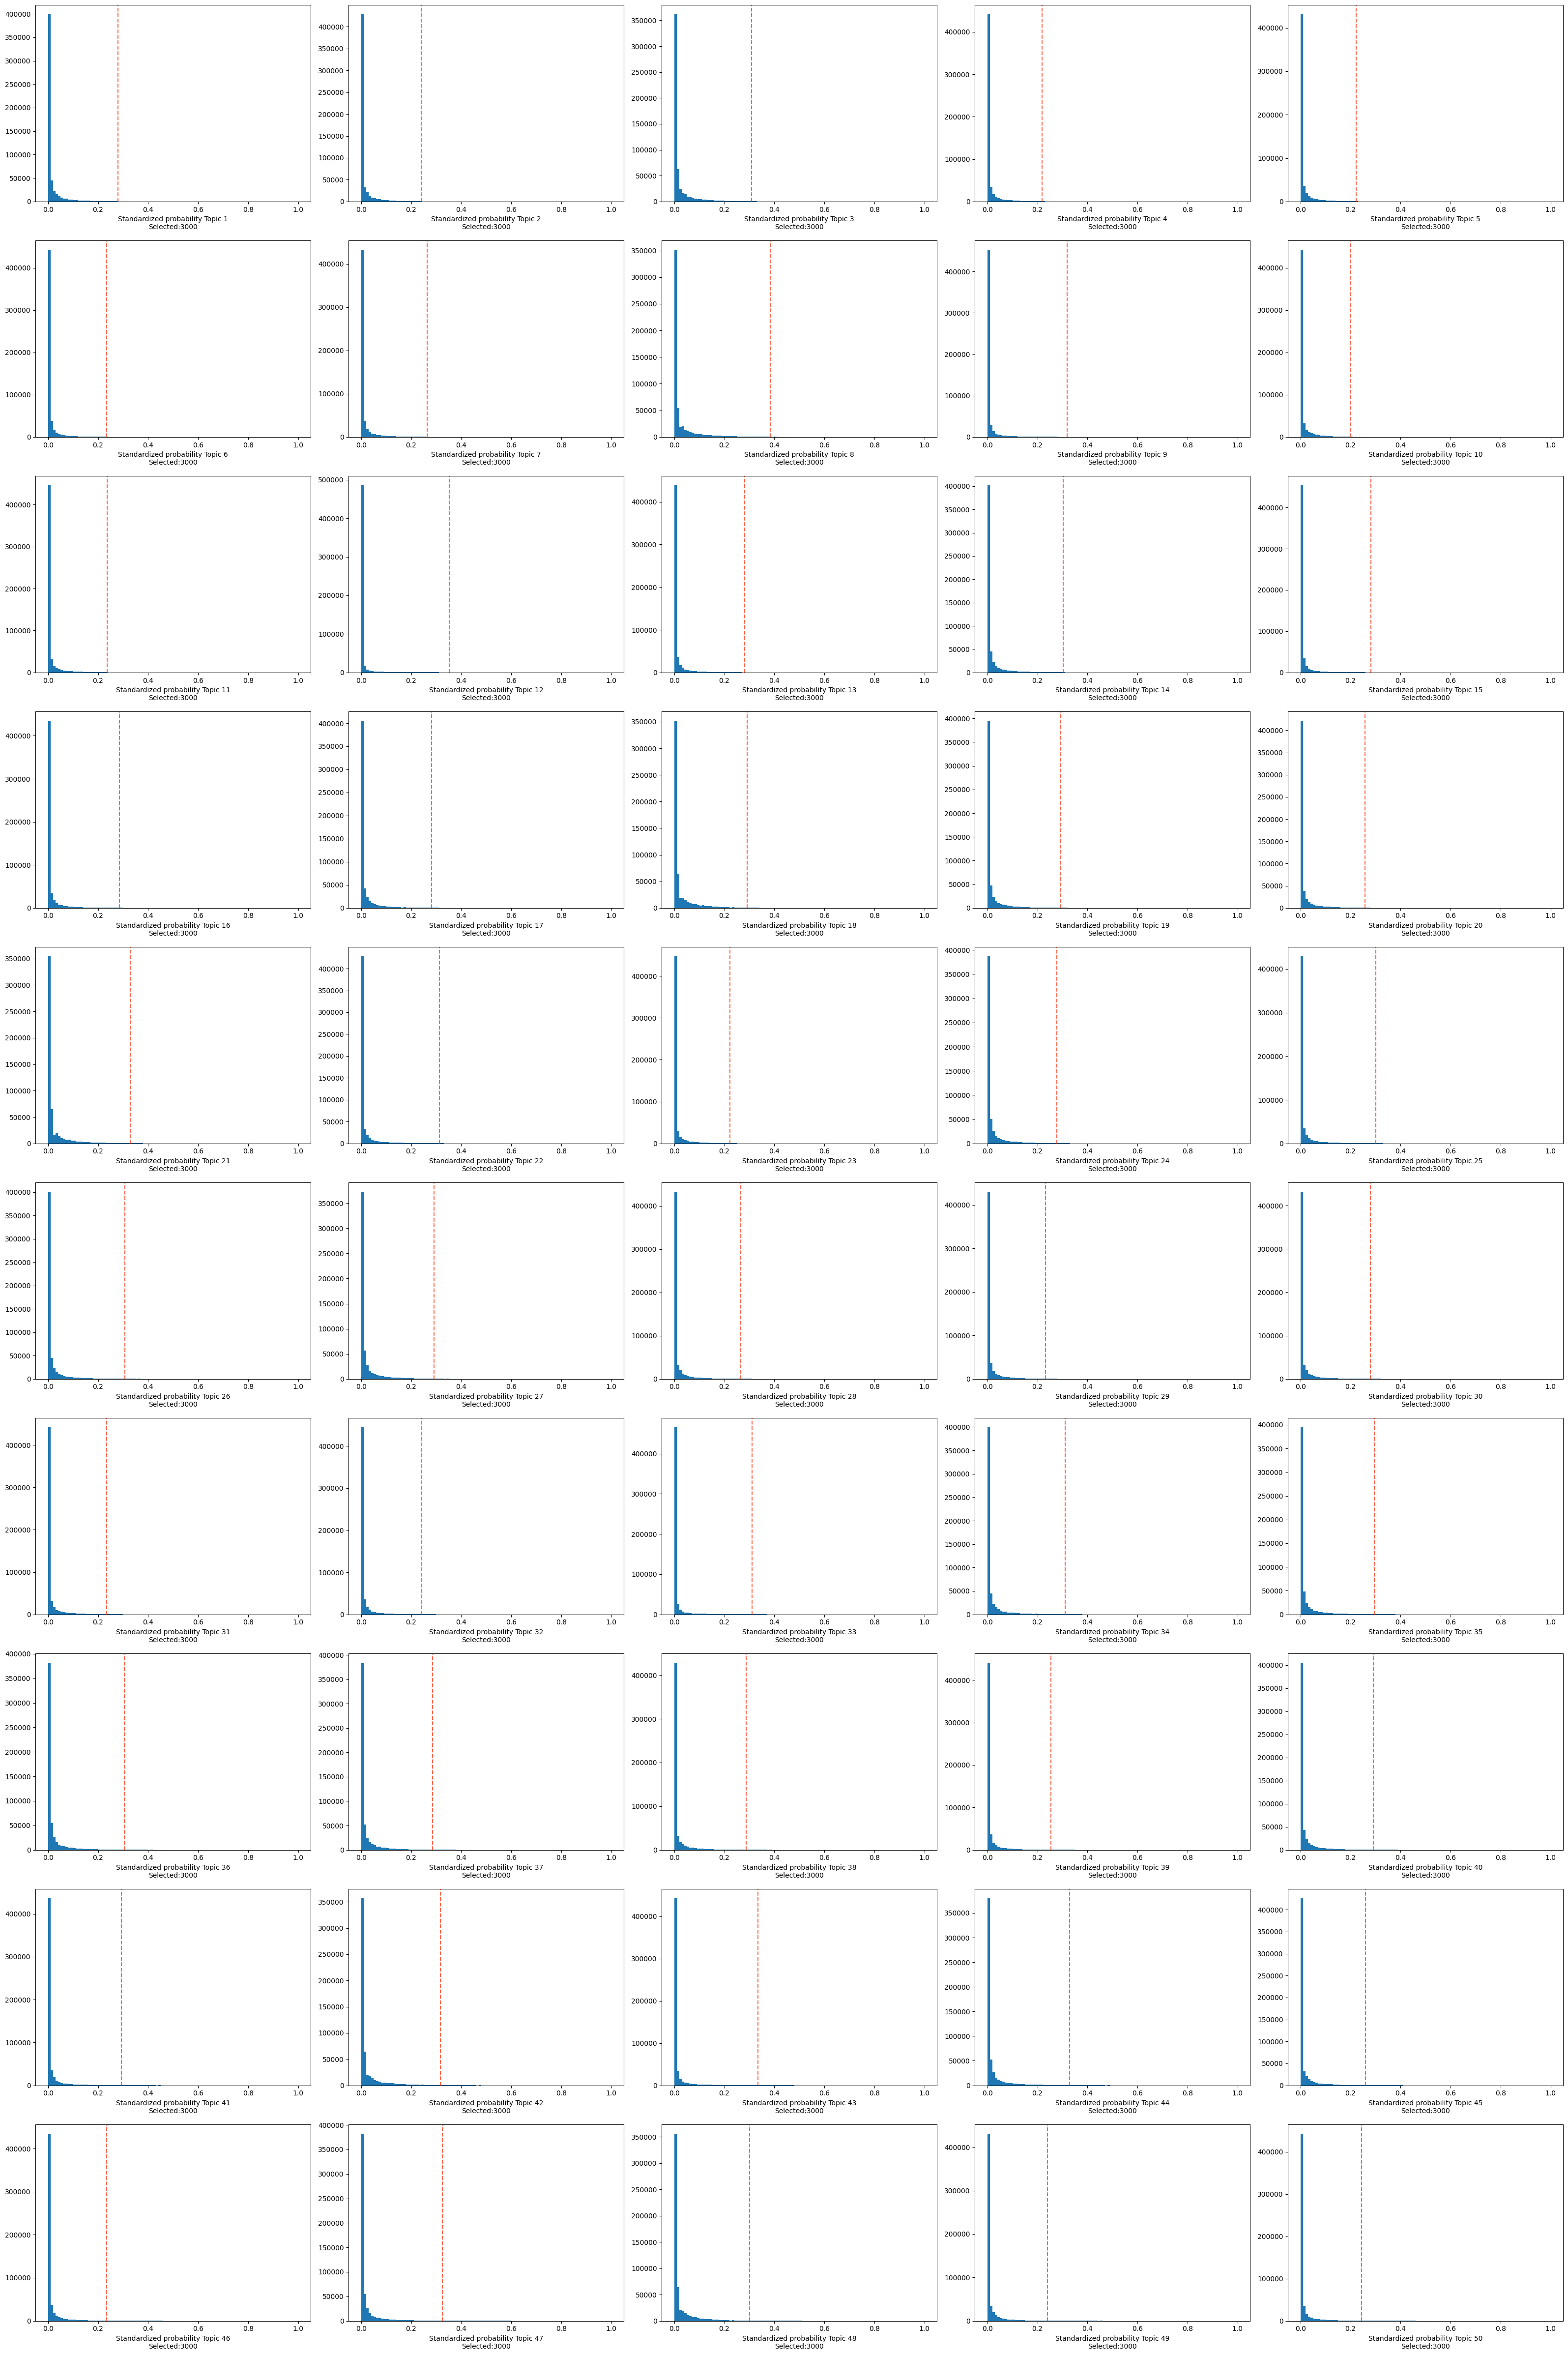

In [29]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_object, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)

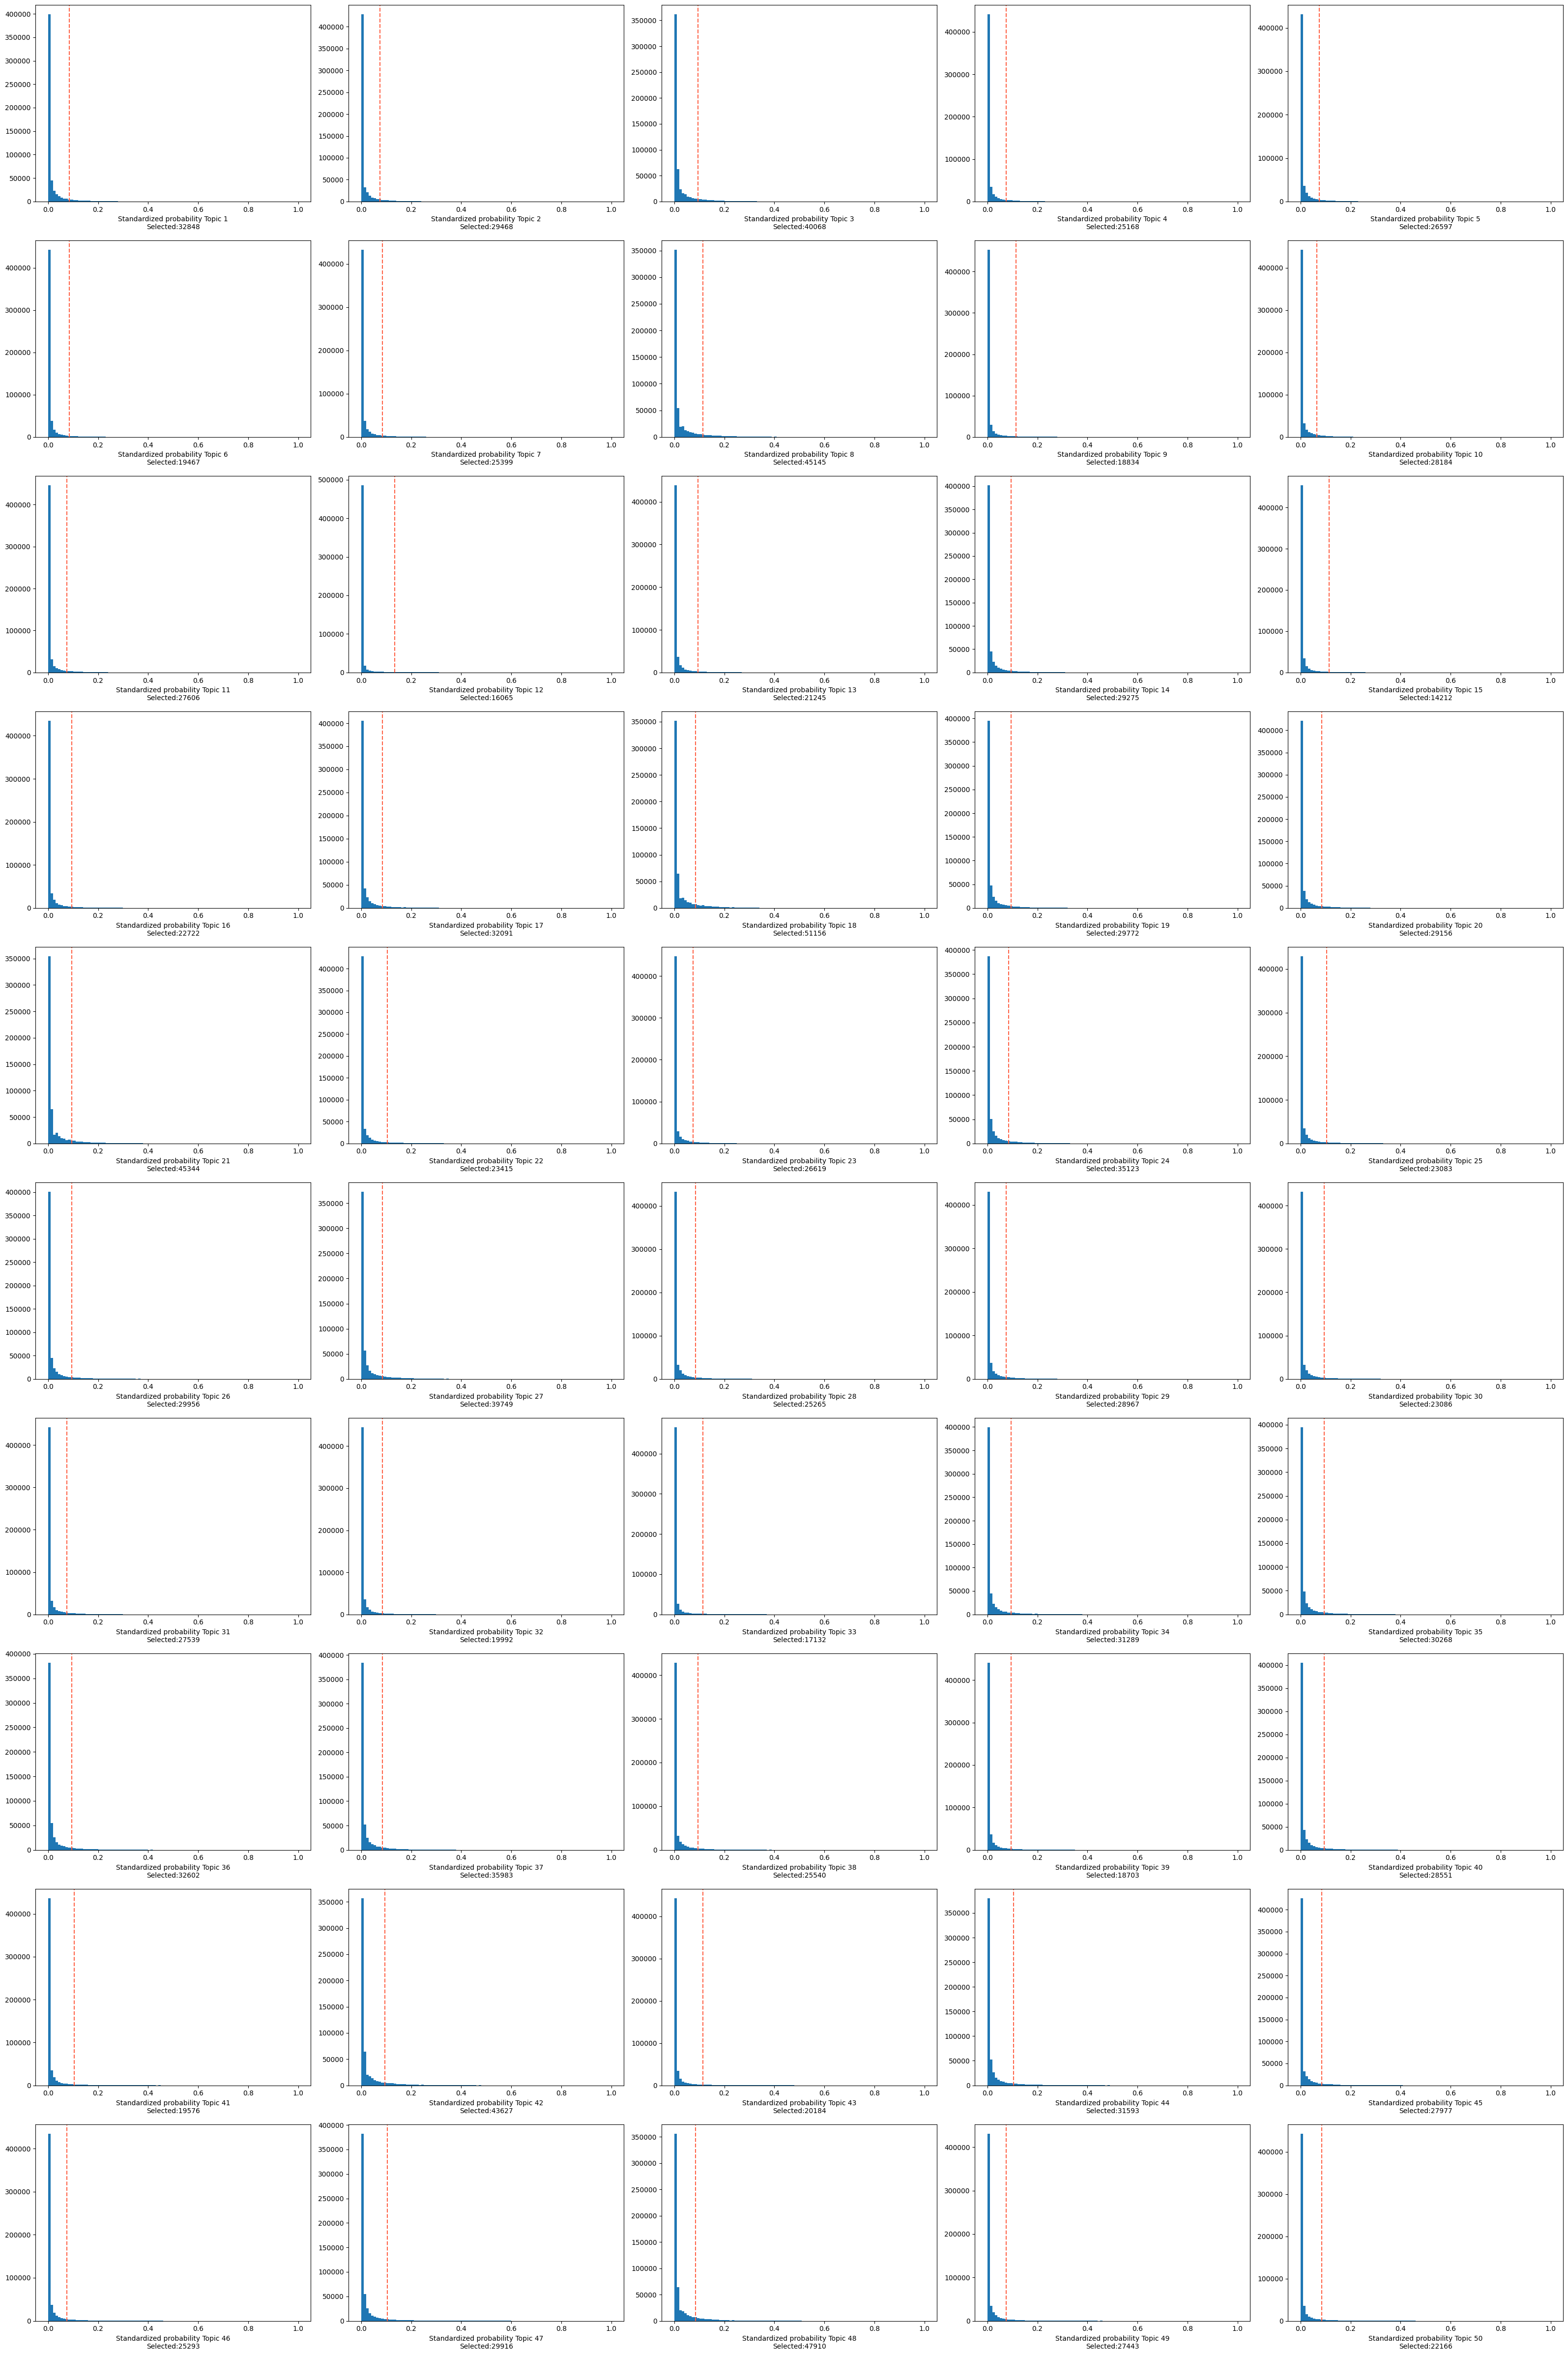

In [30]:
region_bin_topics_otsu = binarize_topics(
    cistopic_object, method='otsu',
    plot=True, num_columns=5
)

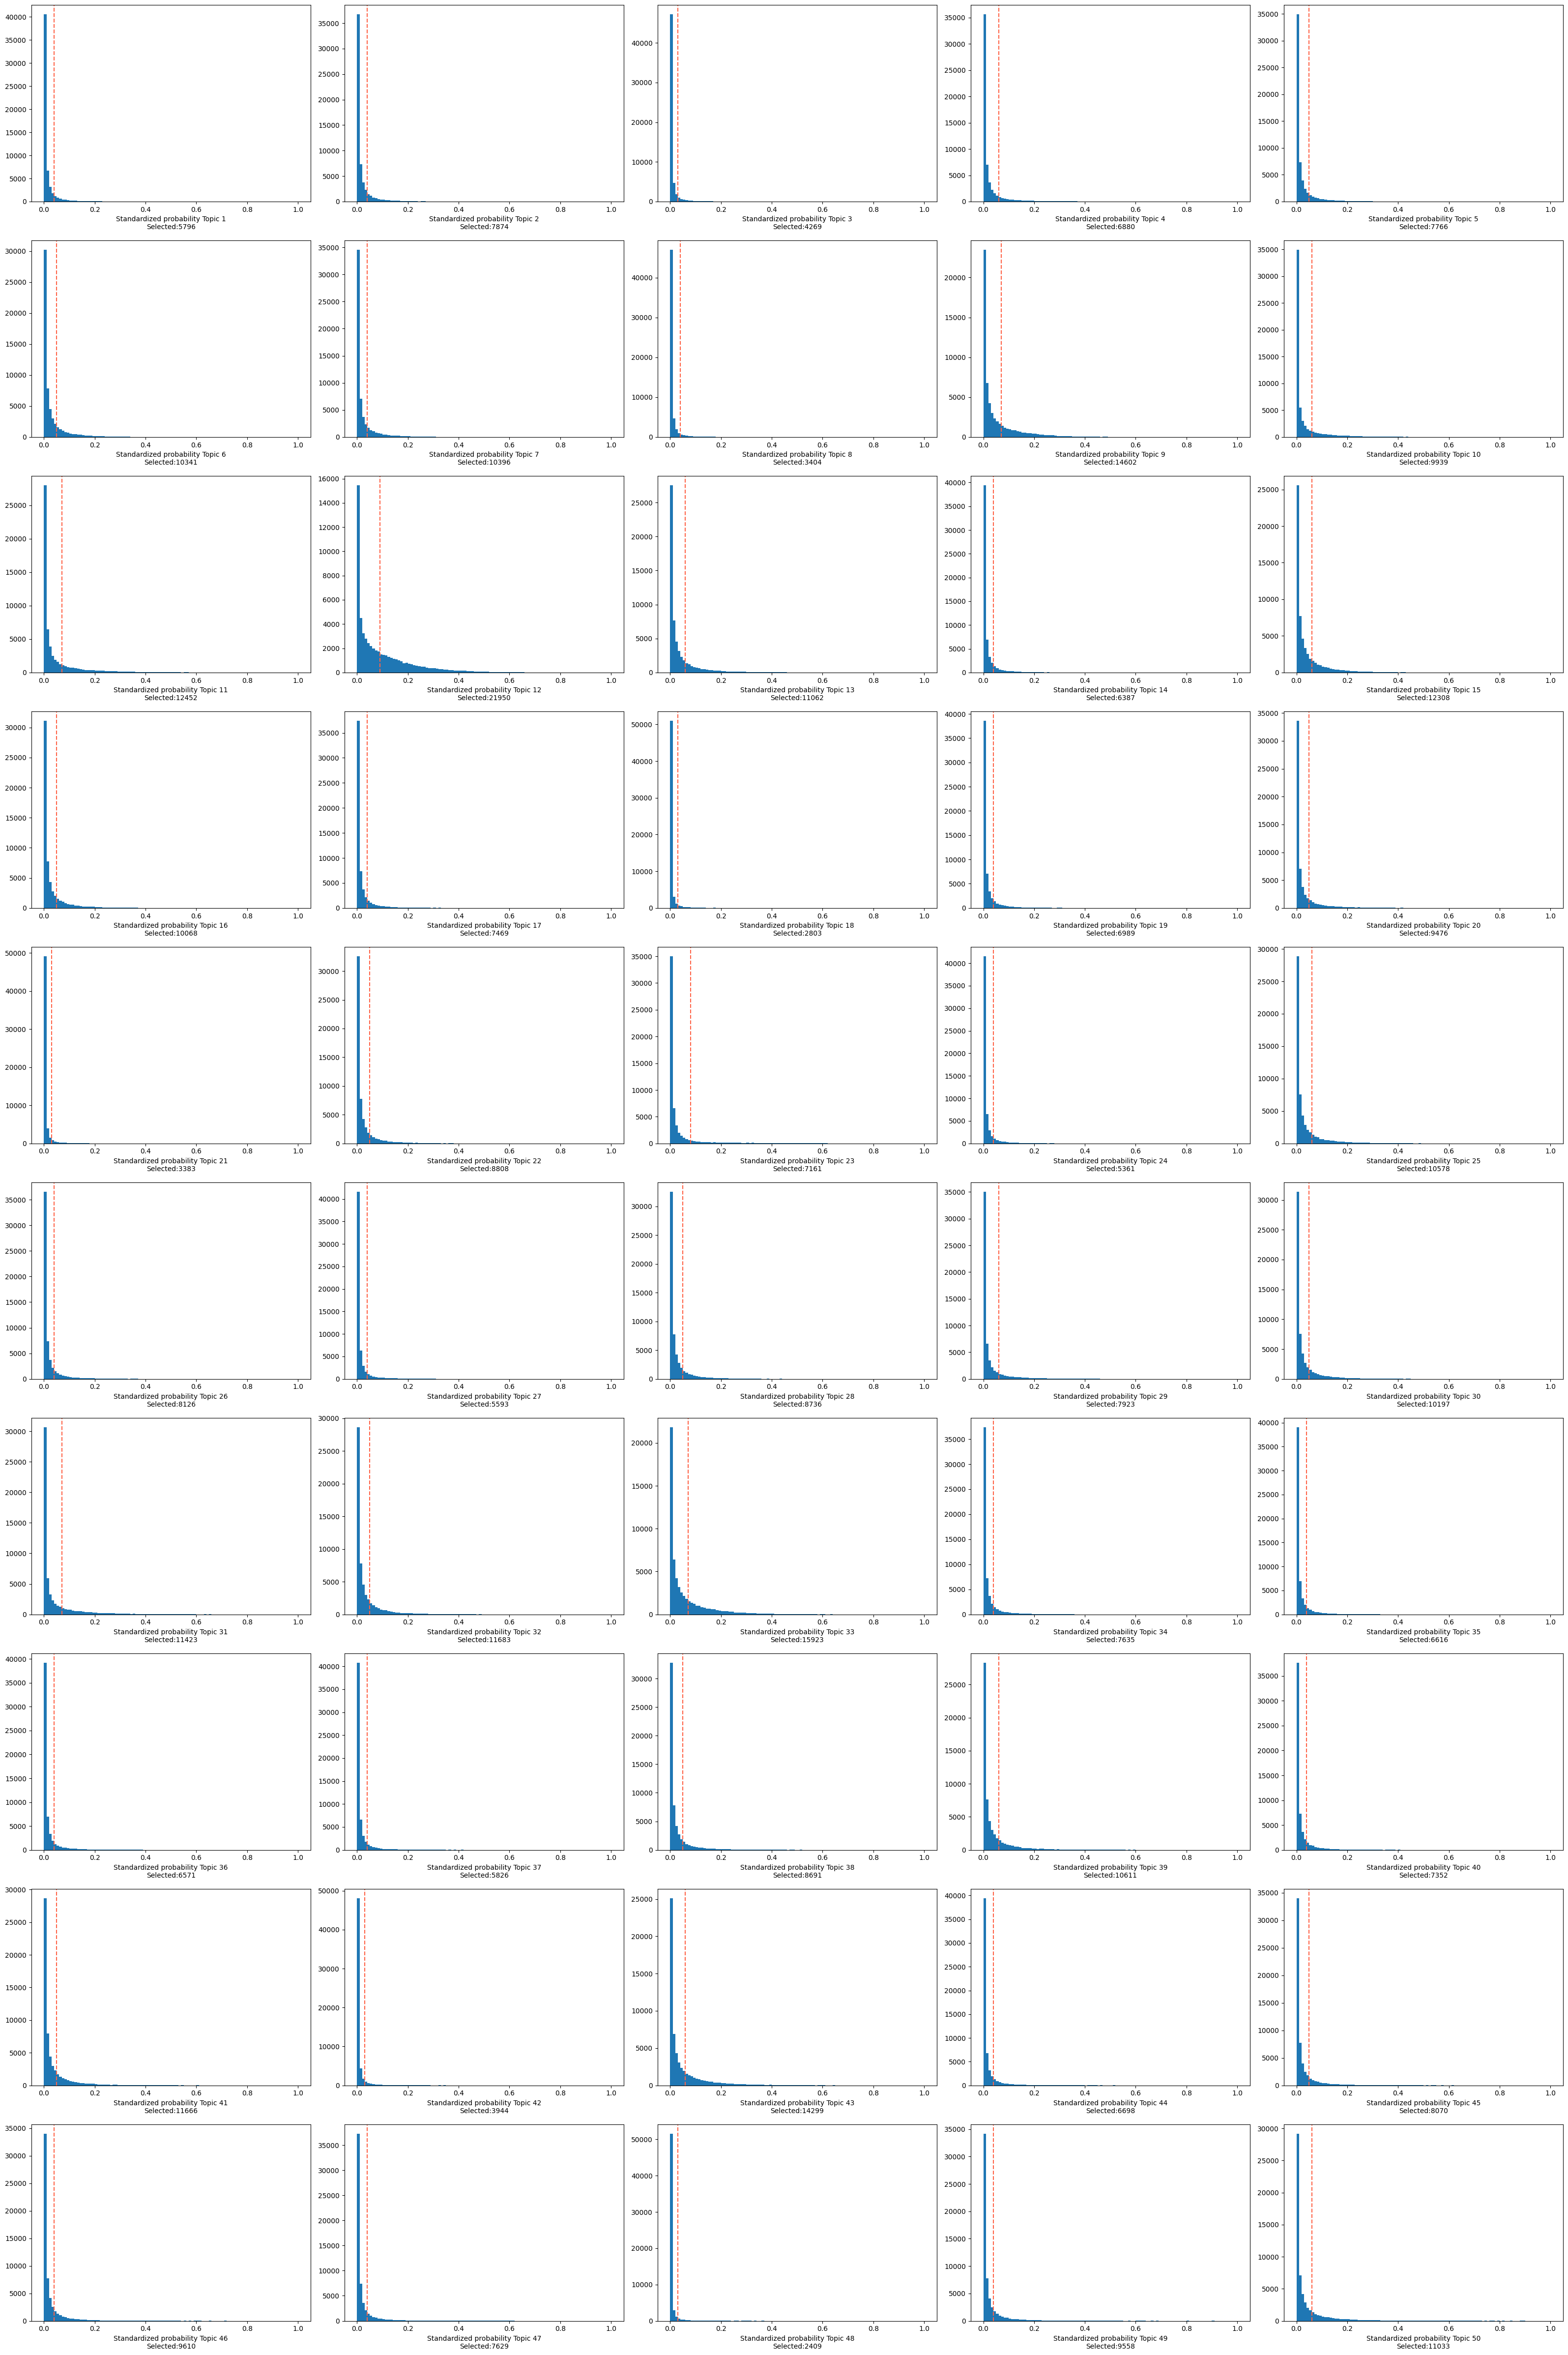

In [31]:
binarized_cell_topic = binarize_topics(
    cistopic_object,
    target="cell",
    method="li",
    plot=True,
    num_columns=5, 
    nbins=100
)

In [32]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [33]:
topic_qc_metrics = compute_topic_metrics(cistopic_object)

In [34]:
fig_dict={}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Gini_index', 
    var_color='Gini_index', plot=False, return_fig=True
)

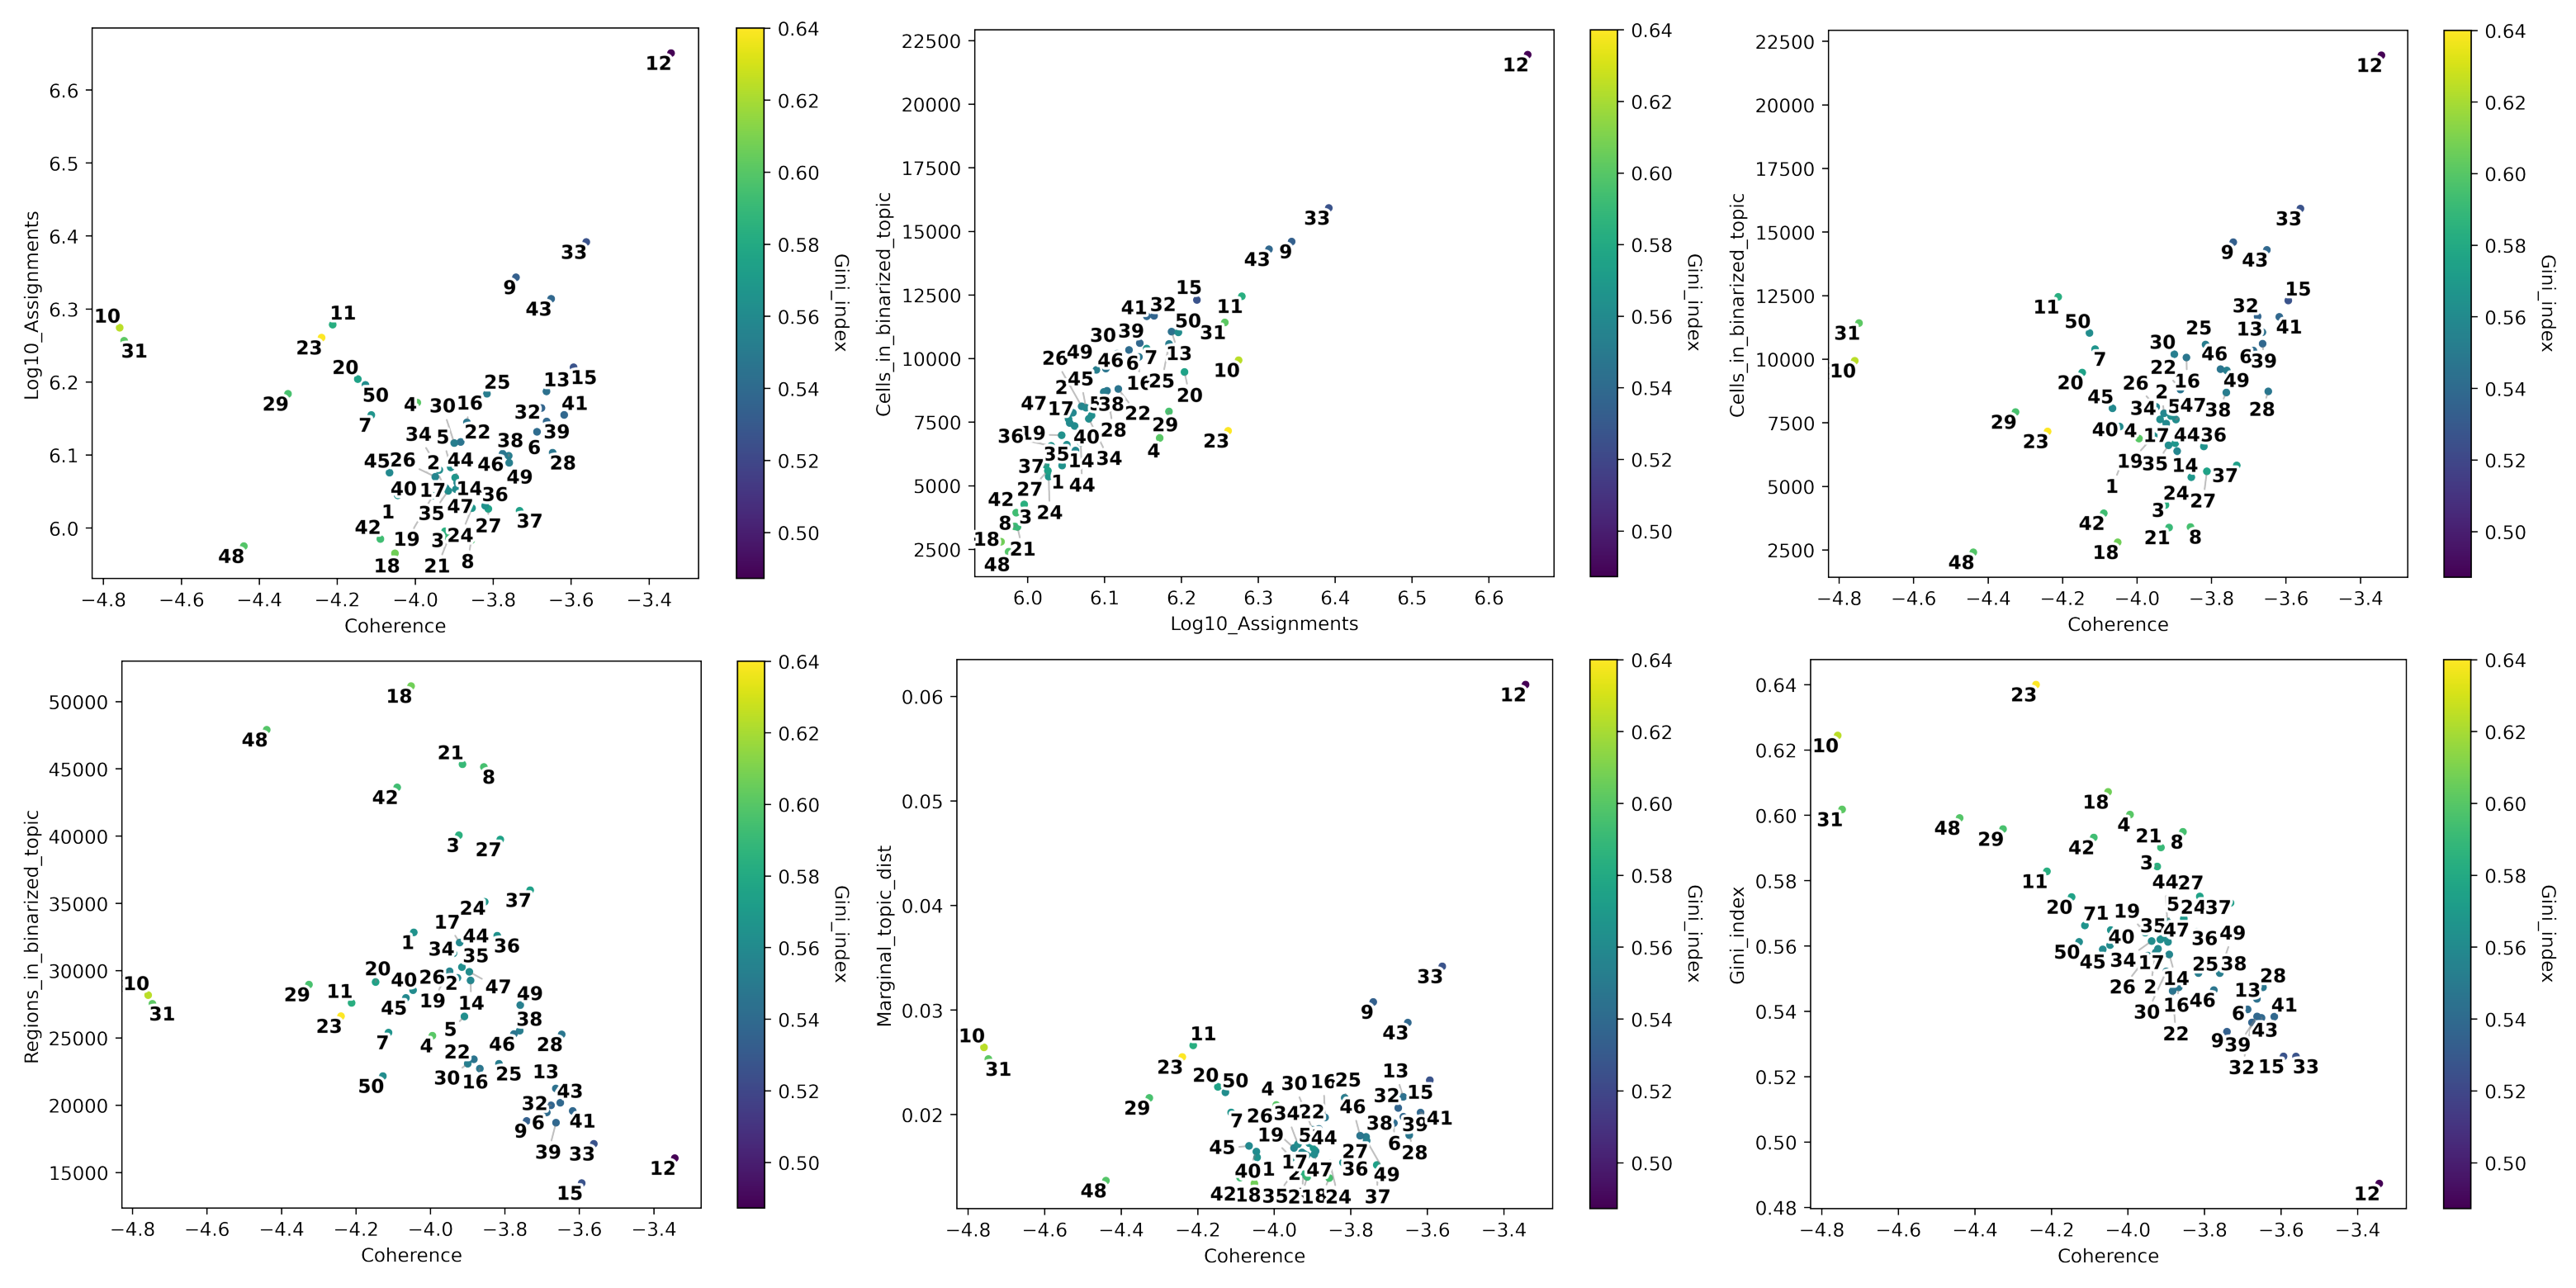

In [35]:
fig = plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_])
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [36]:
topic_annot = topic_annotation(
    cistopic_object,
    annot_var="Cell_type",
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr=0.2
)

In [37]:
topic_annot

Cell_type  \
Topic1                           PVALB_4, PVALB_6, PVALB_7   
Topic2                                    PVALB_4, PVALB_6   
Topic3                                             PVALB_4   
Topic4                           PVALB_1, PVALB_5, PVALB_2   
Topic5                           PVALB_1, PVALB_5, PVALB_2   
Topic6                  PVALB_9, PVALB_8, PVALB_6, PVALB_5   
Topic7                           PVALB_1, PVALB_5, PVALB_2   
Topic8                                             PVALB_4   
Topic9                           PVALB_9, PVALB_8, PVALB_6   
Topic10                          PVALB_4, PVALB_6, PVALB_2   
Topic11                          PVALB_9, PVALB_8, PVALB_7   
Topic12  PVALB_1, PVALB_9, PVALB_8, PVALB_3, PVALB_5, P...   
Topic13                 PVALB_9, PVALB_8, PVALB_6, PVALB_7   
Topic14                                   PVALB_4, PVALB_6   
Topic15                 PVALB_1, PVALB_9, PVALB_8, PVALB_7   
Topic16                          PVALB_9, PVALB_8, PVALB_6   
Topic17                                   PVALB_4, PVALB_6   
Topic18                                            PVALB_4   
Topic19                          PVALB_4, PVALB_3, PVALB_6   
Topic20                                   PVALB_6, PVALB_7   
Topic21                                            PVALB_4   
Topic22                                   PVALB_6, PVALB_7   
Topic23                          PVALB_1, PVALB_5, PVALB_2   
Topic24                                   PVALB_4, PVALB_6   
Topic25                          PVALB_9, PVALB_6, PVALB_7   
Topic26                                   PVALB_6, PVALB_7   
Topic27                          PVALB_4, PVALB_6, PVALB_7   
Topic28                          PVALB_9, PVALB_8, PVALB_6   
Topic29                                   PVALB_9, PVALB_7   
Topic30                 PVALB_8, PVALB_4, PVALB_3, PVALB_6   
Topic31                                   PVALB_4, PVALB_3   
Topic32                 PVALB_9, PVALB_6, PVALB_7, PVALB_5   
Topic33        PVALB_8, PVALB_4, PVALB_3, PVALB_5, PVALB_2   
Topic34                                            PVALB_6   
Topic35                                   PVALB_6, PVALB_7   
Topic36                          PVALB_4, PVALB_6, PVALB_7   
Topic37                                   PVALB_4, PVALB_6   
Topic38                 PVALB_9, PVALB_8, PVALB_6, PVALB_7   
Topic39                                   PVALB_8, PVALB_6   
Topic40                          PVALB_4, PVALB_3, PVALB_6   
Topic41                          PVALB_9, PVALB_8, PVALB_6   
Topic42                                   PVALB_4, PVALB_3   
Topic43                 PVALB_9, PVALB_8, PVALB_6, PVALB_7   
Topic44                                   PVALB_6, PVALB_7   
Topic45                          PVALB_9, PVALB_6, PVALB_7   
Topic46                                   PVALB_6, PVALB_7   
Topic47                                   PVALB_4, PVALB_6   
Topic48                                   PVALB_4, PVALB_3   
Topic49                                   PVALB_4, PVALB_6   
Topic50                                   PVALB_6, PVALB_5   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.099824                  0.738659       False  
Topic2              0.135614                  0.687661       False  
Topic3              0.073525                  0.106645       False  
Topic4              0.118494                  0.135355       False  
Topic5              0.133754                  0.135355       False  
Topic6              0.178103                  0.724725       False  
Topic7               0.17905                  0.135355       False  
Topic8              0.058627                  0.106645       False  
Topic9               0.25149                  0.673125       False  
Topic10             0.171179                  0.721143       False  
Topic11              0.21446                  0.143106       False  
Topic12             0.378044                  0.261341    

## DAR

In [38]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [39]:
imputed_acc_obj = impute_accessibility(
    cistopic_object,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2024-05-27 15:01:49,291 cisTopic     INFO     Imputing region accessibility
2024-05-27 15:01:49,291 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-05-27 15:01:55,280 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-05-27 15:02:01,243 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-05-27 15:02:07,193 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-05-27 15:02:13,225 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-05-27 15:02:19,184 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-05-27 15:02:25,144 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-05-27 15:02:31,087 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-05-27 15:02:37,045 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-05-27 15:02:43,011 cisTopic     

In [40]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2024-05-27 15:04:36,626 cisTopic     INFO     Normalizing imputed data
2024-05-27 15:06:40,037 cisTopic     INFO     Done!


2024-05-27 15:06:42,139 cisTopic     INFO     Calculating mean
2024-05-27 15:07:07,248 cisTopic     INFO     Calculating variance


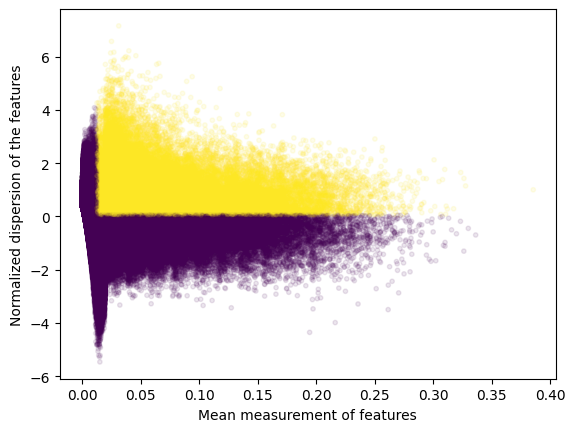

2024-05-27 15:12:33,348 cisTopic     INFO     Done!


In [41]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp=0.05,
    min_mean=0.0125,
    max_mean=3,
    max_disp=np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

In [42]:
len(variable_regions)

64650

In [44]:
markers_dict = find_diff_features(
    cistopic_object,
    imputed_acc_obj,
    variable="Cell_type",
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1),
    n_cpu=20,
    _temp_dir="/tscc/nfs/home/biy022/tmp/"
)

2024-05-27 15:13:30,480	INFO worker.py:1724 -- Started a local Ray instance.


2024-05-27 15:13:31,562 cisTopic     INFO     Subsetting data for PVALB_1 (2919 of 58062)
2024-05-27 15:13:36,004 cisTopic     INFO     Computing p-value for PVALB_1
2024-05-27 15:14:02,741 cisTopic     INFO     Computing log2FC for PVALB_1
2024-05-27 15:14:04,708 cisTopic     INFO     PVALB_1 done!
2024-05-27 15:14:04,725 cisTopic     INFO     Subsetting data for PVALB_2 (1944 of 58062)
2024-05-27 15:14:05,844 cisTopic     INFO     Computing p-value for PVALB_2
2024-05-27 15:14:28,409 cisTopic     INFO     Computing log2FC for PVALB_2
2024-05-27 15:14:29,029 cisTopic     INFO     PVALB_2 done!
2024-05-27 15:14:29,072 cisTopic     INFO     Subsetting data for PVALB_3 (1967 of 58062)
2024-05-27 15:14:30,191 cisTopic     INFO     Computing p-value for PVALB_3
2024-05-27 15:14:52,271 cisTopic     INFO     Computing log2FC for PVALB_3
2024-05-27 15:14:52,892 cisTopic     INFO     PVALB_3 done!
2024-05-27 15:14:52,934 cisTopic     INFO     Subsetting data for PVALB_4 (6192 of 58062)
2024-05

In [45]:
from pycisTopic.clust_vis import plot_imputed_features

In [46]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  PVALB_1: 26347
  PVALB_2: 26874
  PVALB_3: 21943
  PVALB_4: 21515
  PVALB_5: 26159
  PVALB_6: 34202
  PVALB_7: 26362
  PVALB_8: 26265
  PVALB_9: 27849


## Save region sets

In [50]:
os.makedirs("pycistopic_outputs/region_sets", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topics_otsu", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topcis_top_3k", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/DARs_celltypes", exist_ok = True)

In [51]:
from pycisTopic.utils import region_names_to_coordinates

In [52]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topics_otsu/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [53]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topcis_top_3k/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [54]:
for subtype in markers_dict:
    region_names_to_coordinates(
        markers_dict[subtype].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/DARs_celltypes/", f"{subtype}.bed"),
        sep="\t", header=False, index=False
    )

In [56]:
cistopic_object.cell_names[0:5]

['R_20220217E_S1CR65_GCCAAGACACAGCAGAATCCTGTA',
 'R_20210429B_A1CR3_AATCCGTCGTCTGTCACAATGGAA',
 'R_20210513B_S1CR30_CAACCACACATACCAAACATTGGC',
 'R_20210506C_M1CR10_ACAAGCTAAGTACAAGCACTTCGA',
 'R_20220217F_FIR83_TGGCTTCAAACTCACCCACTTCGA']